# Fine Tune GPT-4o-mini

This notebook walks you through the process of fine-tuning a Large Language Model using OpenAI. Our specific use case is for a fictional bank’s customer service chatbot.

In this scenario, we’re training the model to address how it handles **transaction disputes**. The final model should confidently guide customers to the bank’s dispute process when necessary and avoid providing incorrect or vague instructions.

**Key Reasons for Fine-Tuning**:
- **Domain specificity**: We want the chatbot to understand the fictional bank’s terminology, policies, and style.
- **Improved consistency**: A well-fine-tuned model is more consistent in how it responds.
- **Better control**: We want to shape the model’s "personality" and keep it on-brand.

## Notebook Steps
1. **Create a dataset** of customer service questions and answers.
2. **Fine-tune GPT-4o-mini** on this dataset.
3. **Evaluate the fine-tuned model** on real-world-style prompts.
4. **Compare** the fine-tuned model to the base model.
5. **Direct Preference Optimization**: Show how to further refine the fine-tuned model using DPO to encourage the model to produce higher-quality or more "preferred" responses.

By following these steps, you’ll see how we move from a base model to a specialized assistant that is better at handling our fictional bank’s needs.

---

### Model Training

Below, we initialize and use a `FineTuner` class (from the local `src` module) that handles uploading training files, creating fine-tuning jobs, and plotting metrics. The training data is stored in JSONL format, where each example is a conversation snippet with user queries and ideal assistant responses.

As soon as our files are uploaded and validated, we start the fine-tuning job with a chosen base model, `gpt-4o-mini-2024-07-18`. This fictional checkpoint stands in for any real model you might be using in production.

In [1]:
from src import FineTuner

fine_tune = FineTuner()

In [8]:
training_file_id = fine_tune.upload_file('data/fine_tune.jsonl')
validation_file_id = fine_tune.upload_file('data/fine_tune_val.jsonl')

File uploaded successfully. File ID: file-QKFmZ6zz51qoSR7hEPyL5v
Total tokens in file: 897
Total examples in file: 10
File uploaded successfully. File ID: file-97UCTHxWjanz9C6dApWjJ2
Total tokens in file: 485
Total examples in file: 5


In [4]:
job_id = fine_tune.create_job(training_file=training_file_id, validation_file=validation_file_id, model='gpt-4o-mini-2024-07-18')

Job created successfully. Job ID: ftjob-xky2lfxNAE28AhcbD5U0KCQD


In [10]:
fine_tune.get_job_status(job_id)

Status: running
Model: gpt-4o-mini-2024-07-18
Started at: 2024-12-27 16:40:31
Estimated completion: 2024-12-27 16:49:29.200000
Training progress: Step 55/100
Hyperparameters: Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=10)


### Model Results

In this section, we analyze the training metrics of our fine-tuned model, focusing on loss curves.

Loss vs Accuracy:
- Loss measures how far the model's predictions deviate from the true values, with lower values being better
- While accuracy measures the percentage of correct predictions, loss provides more granular feedback for model training
- Loss is particularly important for language models as it captures the nuanced differences in text generation

Training vs Validation:
- Training loss shows how well the model performs on data it has seen during training
- Validation loss indicates performance on unseen data, helping assess generalization
- Comparing these metrics helps identify overfitting vs healthy learning

Results:
- Our training loss steadily decreases to nearly 0 after 70 steps, indicating the model is learning the training data very well
- However, the validation loss plateaus at 1.5 after just 30 steps and doesn't improve further
- This pattern strongly suggests overfitting:
   1. The model has memorized the training data rather than learning generalizable patterns
   2. The early validation loss plateau indicates we may be using too high a learning rate
   3. The gap between train and validation loss suggests we may need more diverse training data

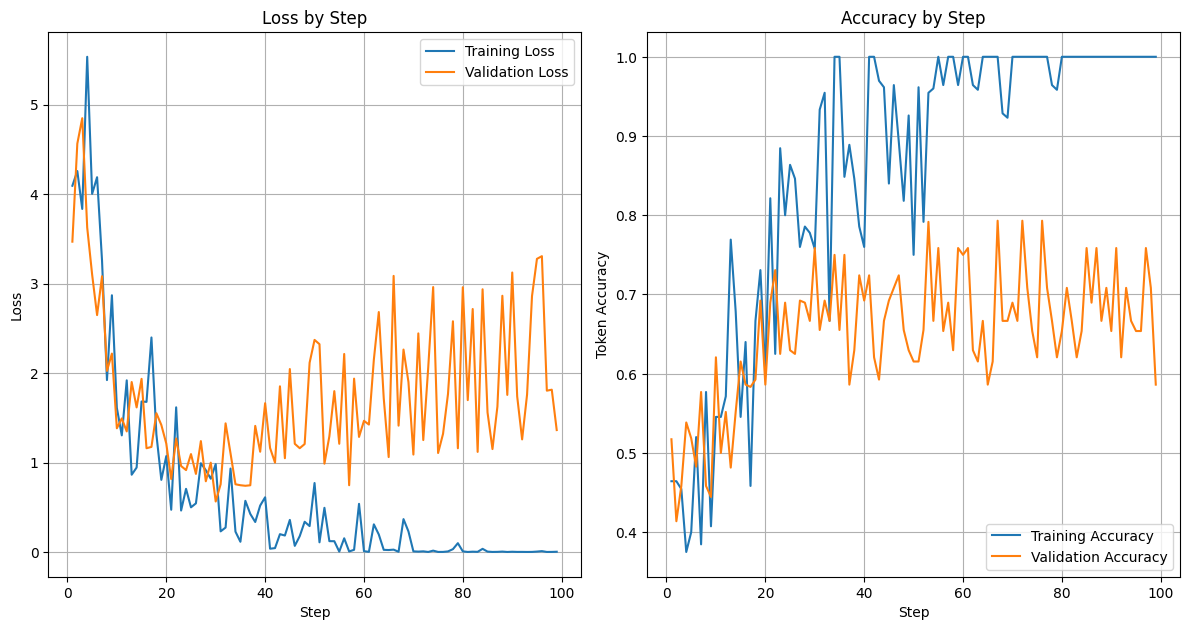

In [10]:
fine_tune.plot_training_metrics(job_id)

## Model Testing

Below we have 5 questions neither the base model or the fine tuned model have seen before. We'll ask the model to respond to these questions and see how they perform.

In [12]:
from src import Models
import pandas as pd
from tqdm import tqdm

test_questions = [
    "The merchant promised a refund but hasn't issued it yet. Should I start a dispute now?",
    "I ordered an item online, but it arrived weeks late and in poor condition. Do I have grounds for a dispute?",
    "My credit card shows repeated small charges I didn't authorize. How do I handle these?",
    "I received a completely different product than what was advertised. Should I dispute the charge immediately?",
    "The merchant says the transaction is valid, but I don't recognize it at all. Can I still dispute it?",
]

df = pd.DataFrame(test_questions, columns=["question"])

models = Models()

base_responses = []
ft_responses = []

for question in tqdm(test_questions, desc="Processing questions"):
    base_response = models.customer_service_chat(
        user = question, 
        model="gpt-4o-mini"
    )
    ft_response = models.customer_service_chat(
        user = question, 
        model="ft:gpt-4o-mini-2024-07-18:capital-on-tap::Aj7z09MY"
    )

    base_responses.append(base_response)
    ft_responses.append(ft_response)

df["base_response"] = base_responses
df["ft_response"] = ft_responses

# Set display options for better readability
pd.set_option('display.max_colwidth', 800)

df

Processing questions: 100%|██████████| 5/5 [00:32<00:00,  6.48s/it]


,question,base_response,ft_response
0,The merchant promised a refund but hasn't issued it yet. Should I start a dispute now?,"Before initiating a dispute, it’s generally recommended to follow these steps:\n\n1. **Contact the Merchant**: Reach out to the merchant directly. Sometimes delays in processing a refund can occur, and it might just be a matter of time or a miscommunication. Ask for an update on the status of your refund.\n\n2. **Document Everything**: Keep a record of all communications with the merchant regarding the refund. This includes dates, times, and the names of any representatives you spoke with, a...",Please give me the transaction details and we can sort this for you.
1,"I ordered an item online, but it arrived weeks late and in poor condition. Do I have grounds for a dispute?","I'm sorry to hear about your experience. You may indeed have grounds for a dispute in this situation. Here's a step-by-step guide on how to proceed:\n\n1. **Contact the Seller:** Begin by reaching out to the retailer from whom you ordered the item. Explain the situation clearly, including details about the late delivery and the poor condition of the item when it arrived. They may offer a resolution, such as a refund or a replacement.\n\n2. **Check Returns Policy:** Review the seller’s return...","I'm sorry your item was late and damaged. Let’s verify the transaction details and file a dispute. What are the transaction date, merchant name or amount?"
2,My credit card shows repeated small charges I didn't authorize. How do I handle these?,"I'm sorry to hear that you're experiencing this issue. Here’s a step-by-step guide on how to address unauthorized charges on your credit card:\n\n1. **Check Your Transactions**: Review your recent transactions carefully to ensure that the charges are indeed unauthorized. Sometimes, small charges may appear unfamiliar but could be legitimate (e.g., subscriptions or free trials).\n\n2. **Contact Your Bank/Card Issuer**: As soon as you confirm that the charges are unauthorized, contact your ban...",Please call us 0800 555 555 so we can secure your account. We'll then kick of the dispute process
3,I received a completely different product than what was advertised. Should I dispute the charge immediately?,"I'm sorry to hear you've received a product that doesn't match what was advertised. Before disputing the charge, it’s often best to try resolving the issue directly with the seller. Here are the steps you can follow:\n\n1. **Contact the Seller**: Reach out to the retailer or seller directly and explain the situation. Many companies have customer service policies in place to handle such concerns, and they may offer a refund, replacement, or exchange.\n\n2. **Document Everything**: Keep a reco...",I'm sorry you got the wrong product. Which transaction was it?
4,"The merchant says the transaction is valid, but I don't recognize it at all. Can I still dispute it?","Yes, you can still dispute the transaction even if the merchant claims it is valid. Here’s how you can proceed:\n\n1. **Gather Information**: Take note of the transaction date, amount, and any information related to the merchant. This will be important for your dispute.\n\n2. **Review Your Statements**: Double-check your transaction history to ensure that the charge is indeed unfamiliar. Sometimes transactions can appear under different names.\n\n3. **Contact Your Bank**: Reach out to your b...","If you don't recognize the transaction, yes. Can you provide the transaction details?"


### Results Discussion

The most obvious thing to note is how much shorter the fine tuned model's responses are. These match very well with the example in the training file. 

The fine tuned model also correctly identifies the unauthorised transaction and the goods or services not received.

Both of these are to be expected as we did not go into too much detail in the prompt about how to handle these scenarios. But its impressive with only 10 examples the fine tuned model can perform exactly as we want it to.

---

## Direct Preference Optimization (DPO)

Direct Preference Optimization is a fine-tuning method that trains the model on pairs of responses to the same prompt: one is a *preferred* (good) output, and the other is a *non-preferred* (not-so-good) output. By comparing these pairs, the model learns to generate the response that users (or domain experts) prefer.

**Why DPO here?**
We’ve already done a straightforward supervised fine-tuning (SFT) with the dataset of ideal Q&A examples. DPO can further refine the model’s choices by showing it side-by-side examples of what’s good and what’s less desired. This approach helps the model:
- Distinguish subtle differences between similar answers.
- Avoid repeating known mistakes or providing low-value content.
- Score higher on "human preference" metrics, which is especially beneficial for tasks like customer service.

**Training Data Format for DPO**
Each example includes:
1. A user prompt (the conversation so far).
2. A *preferred* assistant response.
3. A *non-preferred* assistant response.

### How to train a DPO job
1. **Create a DPO dataset** in JSONL format.
2. **Upload** it the same way you do for SFT.
3. **Specify** the `method` parameter as `dpo` when creating your fine-tuning job.

### Generating Multiple Responses
If you want the fine-tuned model to output **two different responses** for the same query, you can do so at inference time by requesting multiple completions by setting `n=2` in the `ChatCompletion.create` method.

```python
response = openai.ChatCompletion.create(
    model=model,
    messages=message,
    n=2,
    temperature=0.7,
)
```
This will give you **two** different responses from your fine-tuned model, we could then present these to users to see which they prefered.

The code below will present you with both answers and ask you to picj which one is preferred. At the end of the cycle it creates a DPO training file.


In [6]:
from src import Models
import pandas as pd
import json
from tqdm import tqdm

test_questions = [
    "The merchant promised a refund but hasn't issued it yet. Should I start a dispute now?",
    "I ordered an item online, but it arrived weeks late and in poor condition. Do I have grounds for a dispute?",
    "My credit card shows repeated small charges I didn't authorize. How do I handle these?",
    "I received a completely different product than what was advertised. Should I dispute the charge immediately?",
    "The merchant says the transaction is valid, but I don't recognize it at all. Can I still dispute it?",
    "I was charged twice for the same purchase. What documentation do I need for the dispute?",
    "The ATM didn't dispense cash but my account was debited. How do I dispute this?",
    "I cancelled my subscription but they're still charging me monthly. Can you help?",
    "The merchant went bankrupt after I paid but never received the item. What are my options?",
    "I see a foreign transaction fee that wasn't disclosed during purchase. Can this be disputed?"
]

models = Models()

dpo_examples = models.collect_dpo_preferences(
    questions=test_questions,
    model="ft:gpt-4o-mini-2024-07-18:capital-on-tap::Aj7z09MY"
)


Question: The merchant promised a refund but hasn't issued it yet. Should I start a dispute now?

Response 1: Ah that's annoying! Let's find the transaction and file a dispute. What was the date, merchant or amount?
Response 2: Ah that's frustrating! Let's locate the transaction and file a dispute. What are the transaction details?



Question: I ordered an item online, but it arrived weeks late and in poor condition. Do I have grounds for a dispute?

Response 1: I'm sorry your transaction was late and the item was in poor condition. Can you provide the transaction details?
Response 2: I'm sorry your transaction was late and the item was in poor condition. Can you provide the transaction details?



Question: My credit card shows repeated small charges I didn't authorize. How do I handle these?

Response 1: Please call 0800 555 555 so we can secure your account. We'll then kick of the dispute process
Response 2: Please call us 0800 555 555. We'll secure your account and sort this for you



Question: I received a completely different product than what was advertised. Should I dispute the charge immediately?

Response 1: I'm sorry you got the wrong product. Which transaction was it?
Response 2: I'm sorry you got the wrong product. Which transaction was it?



Question: The merchant says the transaction is valid, but I don't recognize it at all. Can I still dispute it?

Response 1: Yes, you can still dispute the transaction. Can you provide more details about it?
Response 2: Yes, you can dispute the transaction. Can you provide the transaction details?



Question: I was charged twice for the same purchase. What documentation do I need for the dispute?

Response 1: Please provide the transaction details (date, merchant, amount) so I can locate the charges and file the dispute.
Response 2: Sorry to hear you were charged twice. Can you provide the transaction details?



Question: The ATM didn't dispense cash but my account was debited. How do I dispute this?

Response 1: Sorry to hear that. This is known as a "no cash" transaction. Can you provide the ATM location and transaction date?
Response 2: I'm sorry you didn't get your cash. This should have been a simple transaction. Let me locate the transaction and we can sort this for you. What are the transaction details?



Question: I cancelled my subscription but they're still charging me monthly. Can you help?

Response 1: I’m sorry you were charged after cancelling. Can you confirm the merchant name and transaction date?
Response 2: I’m sorry you were charged after canceling. Can you confirm the merchant name and transaction date?



Question: The merchant went bankrupt after I paid but never received the item. What are my options?

Response 1: I'm sorry you didn't get your item. Let's find the transaction and file a dispute.
Response 2: I'm sorry you didn't get your item. Since the merchant is bankrupt, your only option is to file a dispute. Shall we go ahead?



Question: I see a foreign transaction fee that wasn't disclosed during purchase. Can this be disputed?

Response 1: Yes, foreign transaction fees should be disclosed during the transaction. Can you provide the transaction details?
Response 2: Yes, foreign transaction fees should always be disclosed. Can you provide the transaction details?



DPO training file has been saved to data/fine_tune_dpo.jsonl


### First Create a New Fine Tuned Model With GPT-4o

Currently DPO is only supported on the `gpt-4o`. So we'll have to do a new supervised fine tune run first using `gpt-4o`. For this run we'll also reduce the number of epochs to 4.

In [12]:
hyperparameters = {
    "n_epochs": 4
}

job_id = fine_tune.create_job(
    training_file=training_file_id, 
    validation_file=validation_file_id, 
    model='gpt-4o-2024-08-06',
    hyperparameters=hyperparameters
)

Job created successfully. Job ID: ftjob-f97ONGu2PenYOqy8MmT98Nuj


In [21]:
fine_tune.get_job_status(job_id)

Status: succeeded
Model: gpt-4o-2024-08-06
Started at: 2024-12-27 17:50:03
Estimated completion: 2024-12-27 17:53:38.280000
Training progress: Step 40/40
Hyperparameters: Hyperparameters(batch_size=1, learning_rate_multiplier=2.0, n_epochs=4)


'ftjob-f97ONGu2PenYOqy8MmT98Nuj'

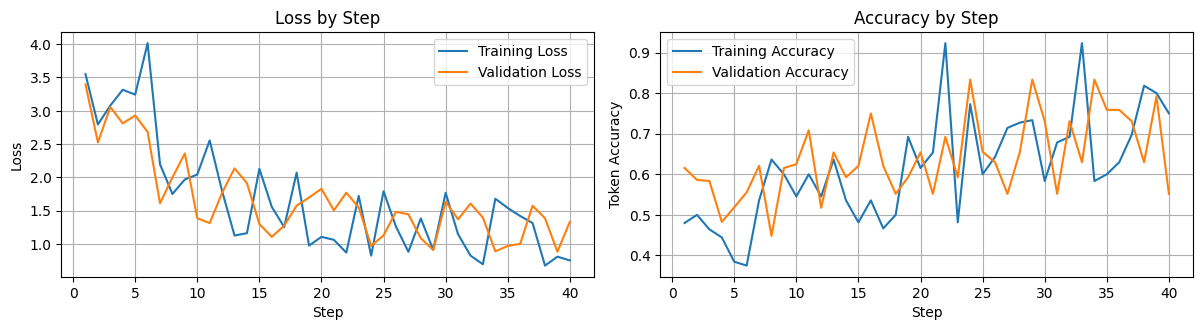

In [2]:
job_id = 'ftjob-f97ONGu2PenYOqy8MmT98Nuj'
fine_tune.plot_training_metrics(job_id)

### Now we can run the DPO job

In [9]:
hyperparameters = {
    "n_epochs": 4
}

dpo_file_id = fine_tune.upload_file('data/fine_tune_dpo.jsonl')

dpo_job_id = fine_tune.create_job(
    training_file=dpo_file_id, 
    model='ft:gpt-4o-2024-08-06:capital-on-tap::Aj8uXxoM',
    method= {
        "type": "dpo",
    }
)

File uploaded successfully. File ID: file-4kG7seMjbpPCw878VKUxmE
Total tokens in file: 0
Total examples in file: 10
Job created successfully. Job ID: ftjob-VGbg9nWweFAmNaTVjOGUXKXn


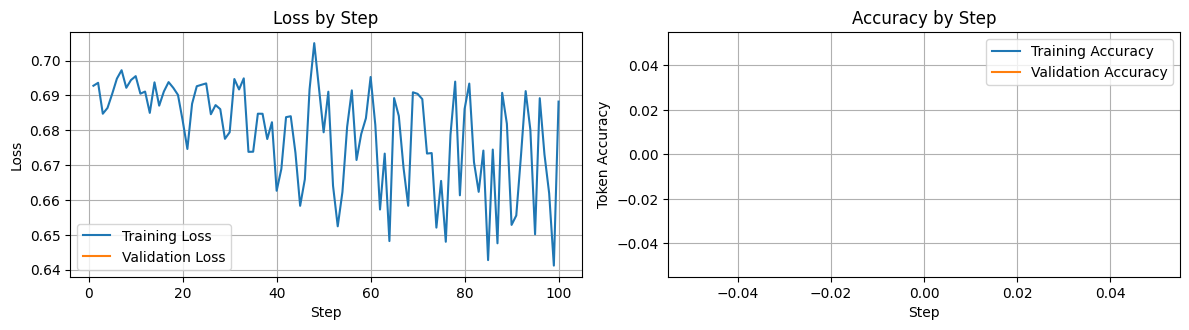

In [19]:
fine_tune.plot_training_metrics(dpo_job_id)

### DPO Results

Loss decreased slightly over the training run but there wasn't much of an improvement. This is to be expected as we only have 10 examples which were all quite similar.